In [ ]:
import pandas as pd
import numpy as np


In [ ]:
data = pd.read_csv('adults dataset preprocessed.csv')

In [ ]:
data_import = pd.read_csv('adults.csv')
data_import

## Data preprocessing 

In [ ]:
data = data_import.copy()

### Label the columns

In [ ]:
# create a new header
header = ["age", "workclass","fnlgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income"]

# Move old header row (which contains first data row) into dataframe
data.loc[-1] = data.columns.tolist()  # 
data.index = data.index + 1
data = data.sort_index().reset_index(drop=True)

# Assign the proper header names
data.columns = header


In [ ]:
data["workclass"].unique()

In [ ]:
data.columns

In [ ]:
data

### Data cleaning 
remove "race" as a feature <br>
remove eductaon bec we have education_num<br>
label encode sex<br>
cahnge native_country to be "Immigrant" or "Non_Immigrant" and standard encode<br>
drop income and store in separate variable<br>
one hot encode = work_class | martial_status | occupation | relationship<br>
scale all values<br>

In [ ]:
data_drop_race = data.copy() #deep copy as modifications will be made without affecting original data
data_drop_race = data_drop_race.drop(['education', 'race'],axis=1)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labedl_encode_sex = data_drop_race
labedl_encode_sex['sex'] = le.fit_transform(labedl_encode_sex['sex'])

native_country = labedl_encode_sex
native_country['native_country'] = native_country['native_country'].apply(lambda x: 0 if x == 'United-States' else 1)

y = native_country['income']

drop_incomes = native_country.drop(['income'],axis=1) 

one_hot_encode = pd.get_dummies(drop_incomes, columns = ['workclass', 'marital_status', 'occupation', 'relationship'], drop_first=False) #drop_first=True used with linear models to avoid dummy variable trap

#one_hot_encoded_data = pd.get_dummies(drop_incomes[['workclass', 'marital_status', 'occupation', 'relationship']], drop_first=False)
#numeric_data = drop_incomes.drop(columns=['workclass', 'marital_status', 'occupation', 'relationship'])
#combined = pd.concat([numeric_data, one_hot_encoded_data], axis=1)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(one_hot_encode)

cleaned_data = pd.DataFrame(scaled_data, columns=one_hot_encode.columns)



In [ ]:
cleaned_data

## Modeling 

In [ ]:
from sklearn.cluster import KMeans

k = 7 #the number of clusters that we want to find
kmeans = KMeans(n_clusters=k,random_state=42)

y_pred = kmeans.fit_predict(cleaned_data) #assign each instance to a group from 0-4, fit the model and predict the clusters
y_pred

#kmeans.cluster_centers_ #get the coordinates of the cluster centers

#kmeans.predict(X_test)#Assigns each test value to a cluster 


In [ ]:
kmeans.inertia_ #sum of squared distances of samples to their closest cluster center, lower is better

### Testsing the number of clusters 

In [ ]:
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []

total_range = range (2,20) #starting from 2 as silhouette score is not defined for k=1 (cant work with one cluster)


for i in total_range:
    #k = i
    kmeans = KMeans(n_clusters=i,random_state=42)
    kmeans.fit(cleaned_data)

    sil_scores.append(silhouette_score(cleaned_data, kmeans.labels_))

    inertias.append(kmeans.inertia_)

In [ ]:
pd.DataFrame(kmeans.labels_).value_counts() 

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(total_range,inertias)

In [ ]:
plt.plot(total_range,sil_scores)

In [ ]:
kmeans = KMeans(n_clusters=9,random_state=42)
kmeans.fit(cleaned_data) #training (fitting) the K-Means algorithm on your dataset.

sil_scores.append(silhouette_score(cleaned_data, kmeans.labels_))  #kmeans.labels_ stores each point with its cluster

inertias.append(kmeans.inertia_)

In [ ]:
y_pred = kmeans.fit_predict(cleaned_data)  # .fit() trains the KMeans model.
                                           #.predict() assigns each sample to its nearest cluster center.
y_pred

In [ ]:
silhouette_score(cleaned_data, y_pred)

### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(cleaned_data)
X2D


In [ ]:
#pd.concat( [pd.DataFrame(data=X2D, columns=['X', 'Y']), pd.Series(y_pred, name = 'Cluster') ], axis =1).to_csv('clustering.csv', index= True)

In [ ]:
x_points = []
y_points = []

for point in X2D:
    x_points.append(point[0])
    y_points.append(point[1])

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X2D[:, 0], X2D[:, 1], 
    c=y_pred,            # color by cluster label
    cmap='viridis', 
    s=40, 
    alpha=0.7
)

# plot cluster centers
centers_2D = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centers_2D[:, 0], centers_2D[:, 1], 
    c='red', 
    s=200, 
    marker='X', 
    label='Centroids'
)

plt.title("K-Means Clustering (PCA-reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

## Clustering for semi-supervised learning 

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import numpy as np

X_digits, y_digits = load_digits(return_X_y = True)




In [ ]:
X_digits

In [ ]:
y_digits

### Apply K-Means clustering to the training data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

k = 50
kmeans = KMeans(n_clusters = k , random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0) #This finds the index of the sample closest to each centroid (argmin means the smallest distance)
X_representative_digit = X_train[representative_digit_idx]

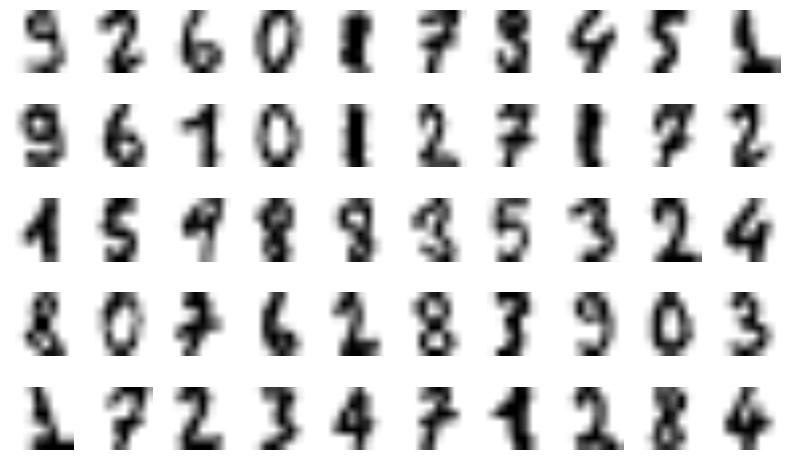

In [34]:
# Plot representative images
plt.figure(figsize=(8, 5))
for index, digit_image in enumerate(X_representative_digit):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(digit_image.reshape(8, 8), cmap='binary', interpolation='bilinear')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [35]:
y_representative_digit = y_train[representative_digit_idx]
y_representative_digit 

array([9, 2, 6, 0, 1, 7, 9, 4, 5, 1, 9, 6, 1, 0, 1, 2, 7, 1, 7, 2, 1, 5,
       9, 8, 8, 3, 5, 3, 2, 4, 8, 0, 7, 6, 2, 8, 3, 9, 0, 3, 1, 7, 2, 3,
       4, 7, 1, 2, 8, 4])

In [36]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_representative_digit, y_representative_digit)
log_reg.score(X_test, y_test)

c:\Users\hamza\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.9133333333333333

In [37]:
from sklearn.cluster import DBSCAN

dbsacn = DBSCAN(eps=0.05, min_samples=5)
dbsacn.fit(cleaned_data)

pd.DataFrame(dbsacn.labels_).value_counts()

0 
-1    32556
 0        5
Name: count, dtype: int64

In [38]:
pd.DataFrame(dbsacn.labels_).value_counts()

0 
-1    32556
 0        5
Name: count, dtype: int64